In [41]:
import requests
from bs4 import BeautifulSoup
import time
import urllib.request
import pandas as pd
import json
import ast

# Approach 1: Using Book API

In [71]:
book_collection_info = []
coverID = 1501
max_coverID = 2000

In [72]:
while coverID < max_coverID:
    if (coverID % 50) == 0:
        print(coverID,' Books Parsed')
    if len(id_lookup[id_lookup[3]==str(coverID)][1]) == 0:
        coverID += 1
        continue
    isbn = id_lookup[id_lookup[3]==str(coverID)][1].iloc[0]
    url = 'https://openlibrary.org/api/books?bibkeys=ISBN:'+isbn+'&jscmd=details&format=json'
    resp = requests.get(url)
    json_details = resp.json()['ISBN:'+isbn]['details']
    
    book_info = [coverID,isbn]
    lst_keys = ['title','authors','publish_date','subjects']
    for key in lst_keys:
        if key not in json_details.keys():
            book_info.append(None)
        else:
            info = json_details[key]
            book_info.append(info)
    
    book_collection_info.append(book_info)
    
    coverID += 1
    time.sleep(2)
    
    
    
    
    
    

1550  Books Parsed
1600  Books Parsed
1650  Books Parsed
1700  Books Parsed
1750  Books Parsed
1800  Books Parsed
1850  Books Parsed
1900  Books Parsed
1950  Books Parsed


In [74]:
coverID

2000

In [75]:
len(book_collection_info)

373

In [76]:
cnt_subjects = 0
for i in range(len(book_collection_info)):
    if book_collection_info[i][5] is None:
        continue
    else:
        cnt_subjects += 1

In [77]:
cnt_subjects

183

In [24]:
def get_metadata(book):
#param: a list of raw info about book
#returns: dictionary of cover id, isbn, title, author, date, and genre

    genres = ['Art', 'Biography', 'Business','Children', 'Christian', 'Classics', 'Comics', 'Contemporary', 'Cookbooks', 
          'Crime','Fantasy', 'Fiction', 'Graphic Novels', 'Historical', 'Fiction', 'History', 'Horror', 'Manga',
          'Music', 'Mystery', 'Nonfiction', 'Paranormal', 'Philosophy', 'Poetry', 'Psychology', 'Religion', 'Romance', 
          'Science', 'Science Fiction', 'Self Help', 'Suspense', 'Sports', 'Thriller', 'Travel', 'Young Adult']
    d = {}
    d['cover_id']= int(book[0])
    
    d['isbn'] = book[1] if book[1] != None else None
    d['title'] = book[2] if book[2] != None else None
    d['author'] = book[3][0]['name'] if book[3] != None else None
    d['date'] = book[4] if book[4] != None else None
    
    if book[5] != None:
        genre_list = [genre for genre in genres if any(genre in xs for xs in book[5])]
        if len(genre_list) == 0:
            genre = None
        else:
            genre = list(set(genre_list))
    else: 
        genre = None
    d['genre'] = genre
    
    return d

In [85]:
metadata = []
for book in book_collection_info:
    metadata.append(get_metadata(book))

In [86]:
df_metadata = pd.DataFrame(metadata)

In [87]:
df_metadata.to_csv('metadata_0_to_500.csv')

In [88]:
df_metadata[df_metadata['genre'].notnull()]

,cover_id,isbn,title,author,date,genre
1,2,0001004344,Mog Forgetful Cat Book,Judith Kerr,"June 1, 1992","[Fiction, Children]"
2,5,0001006789,The Tiger Who Came to Tea,Judith Kerr,"June 3, 1996","[Fiction, Children]"
4,7,0001010468,One Snowy Night (Percy's Park),None,"September 16, 1993",[Fiction]
5,10,0001016199,The Magician's Nephew (Chronicles of Narnia),C. S. Lewis,"October 7, 2002",[Children]
6,16,000102521X,The Fatal Strand (Tales from the Wyrd Museum),None,"October 5, 1998",[Horror]
...,...,...,...,...,...,...
259,466,000200724X,Causeway,Linden Macintyre,August 2006,"[Art, Biography]"
262,473,000200769X,Invisible Armies,Jon Evans,May 2006,[Fiction]
263,474,0002007770,Water for Elephants,Sara Gruen,May 2006,[Fiction]
264,477,0002007800,The Devil's Picnic,Taras Grescoe,February 2006,[Travel]


In [4]:
metadata_0_to_500 = pd.read_csv('metadata_0_to_500.csv')
metadata_501_to_1000 = pd.read_csv('metadata_501_to_1000.csv')
metadata_1001_to_1500 = pd.read_csv('metadata_1001_to_1500.csv')
metadata_1501_to_2000 = pd.read_csv('metadata_1501_to_2000.csv')

In [11]:
df_full = pd.concat([metadata_0_to_500,metadata_501_to_1000,metadata_1001_to_1500,metadata_1501_to_2000]).drop('Unnamed: 0',axis=1)

In [46]:
lst_genre_col = df_full['genre'].tolist()
for i in range(len(lst_genre_col)):
    g_str = lst_genre_col[i]
    if pd.isnull(g_str):
        continue
    else:
        lst_genre_col[i] = ast.literal_eval(g_str)
df_full['genre'] = pd.Series(lst_genre_col)

In [55]:
genres = df_full['genre'].apply(pd.Series)
genres.columns = ['genre','genre_alt1','genre_alt2']

In [57]:
df_full['genre'] = genres['genre']
df_full['genre_alt1'] = genres['genre_alt1']
df_full['genre_alt2'] = genres['genre_alt2']

In [250]:
df_full[df_full['genre'].notnull()].groupby('title')['cover_id'].count().sort_values(ascending=False).head(5)

title
Collins Pocket Guide               5
Stonehenge                         5
Faults and Fixes                   4
Tuscany, the beautiful cookbook    3
Apples                             3
Name: cover_id, dtype: int64

In [252]:
df_full[df_full['genre'].notnull()]['title'].nunique()

523

In [86]:
df_full['year'] = df_full['date'].str.slice(-4)
df_full['year'] = df_full['year'].replace('r 21','1991')
df_full['year'] = pd.to_datetime(df_full['year'], format='%Y')

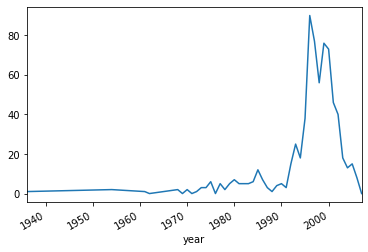

In [95]:
df_full.groupby('year')['genre'].count().plot()

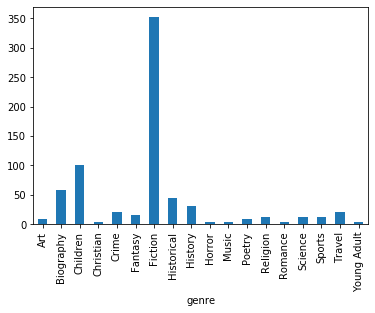

In [101]:
df_full.groupby('genre')['cover_id'].count().plot.bar()

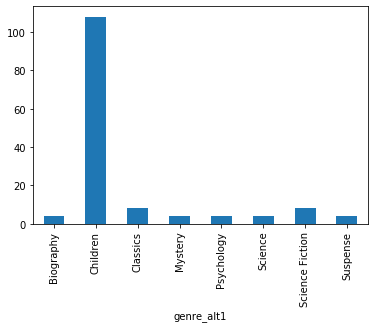

In [103]:
df_full[df_full['genre']=='Fiction'].groupby('genre_alt1')['cover_id'].count().plot.bar()

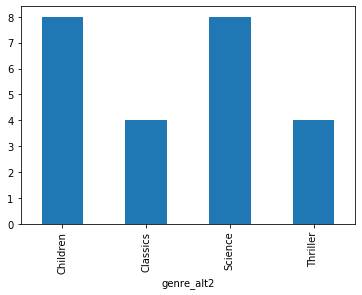

In [104]:
df_full[df_full['genre']=='Fiction'].groupby('genre_alt2')['cover_id'].count().plot.bar()

# Approach 2: Subject API

In [142]:
science_json = requests.get('http://openlibrary.org/subjects/science.json?details=True&limit=500').json()

In [198]:
romance_json = requests.get('http://openlibrary.org/subjects/romance.json?details=True&limit=500').json()

In [201]:
crime_json = requests.get('http://openlibrary.org/subjects/crime.json?details=True&limit=500').json()

In [203]:
horror_json = requests.get('http://openlibrary.org/subjects/horror.json?details=True&limit=500').json()

In [205]:
fantasy_json = requests.get('http://openlibrary.org/subjects/fantasy.json?details=True&limit=500').json()

In [207]:
lst_genres = ['Science','Romance','Crime','Horror','Fantasy']
lst_jsons = [science_json,romance_json,crime_json,horror_json,fantasy_json]
lst_book_info = []
for i in range(5):
    g_json = lst_jsons[i]
    g = lst_genres[i]
    for book in g_json['works']:
        cover_id = str(book['cover_id'])
        title = book['title']
        author = book['authors']
        if author is None or len(author)==0: 
            author = None
        else:
            author = author[0]['name']
        year = book['first_publish_year']
        genre = g
        genre_alts = book['subject']
        book_info = [cover_id,title,author,year,genre,genre_alts]
        lst_book_info.append(book_info)

In [208]:
df_info = pd.DataFrame(lst_book_info)

In [209]:
df_info.columns = ['cover_id','title','author','year','genre','genre_alts']

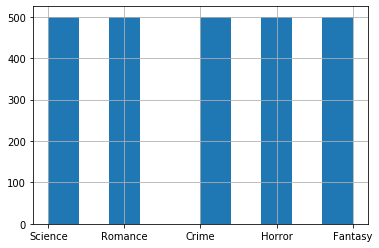

In [217]:
df_info['genre'].hist()